In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("/workspaces/Data-Analyst-Project-Portfolio/Netflix-WatchPattern-Analytics/data/netflix_cleaned.csv")

In [3]:
df['Date'] = pd.to_datetime(df['Watch_Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

In [8]:
user_df = df.groupby('User_ID').agg({
    'Video_Title': 'count',                          
    'Date': [lambda x: x.nunique(), 'min', 'max'] 
})
user_df.columns = ['Total_Watches', 'Active_Days', 'First_Watch', 'Last_Watch']
user_df['Watch_Per_Day'] = user_df['Total_Watches'] / user_df['Active_Days']
user_df['Watch_Duration'] = (user_df['Last_Watch'] - user_df['First_Watch']).dt.days + 1
user_df['Watch_Frequency'] = user_df['Active_Days'] / user_df['Watch_Duration']

# Clean
user_df.replace([float("inf"), float("nan")], 0, inplace=True)
user_df.fillna(0, inplace=True)


In [9]:
features = ['Total_Watches', 'Watch_Per_Day', 'Watch_Frequency']
X = user_df[features]

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

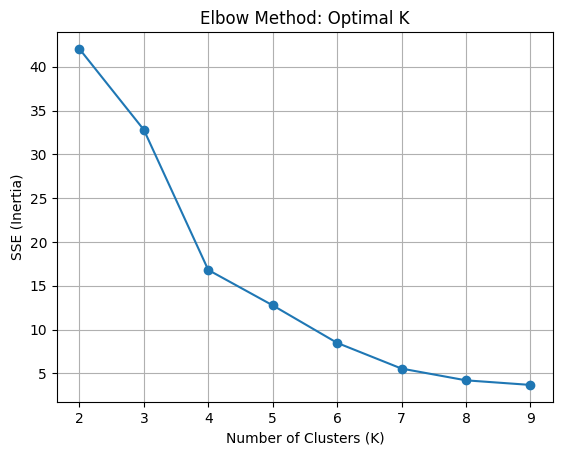

In [10]:
sse = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.plot(K_range, sse, marker='o')
plt.title("Elbow Method: Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE (Inertia)")
plt.grid(True)
plt.show()

In [11]:
optimal_k = 3  # or choose based on elbow/silhouette
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Silhouette Score
score = silhouette_score(X_scaled, user_df['Cluster'])
print(f"Silhouette Score for K={optimal_k}: {score:.2f}")

Silhouette Score for K=3: 0.41


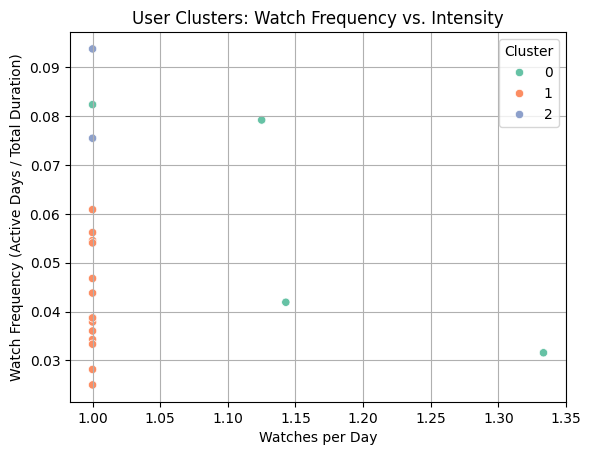

In [12]:
sns.scatterplot(
    x='Watch_Per_Day',
    y='Watch_Frequency',
    hue='Cluster',
    data=user_df,
    palette='Set2'
)
plt.title("User Clusters: Watch Frequency vs. Intensity")
plt.xlabel("Watches per Day")
plt.ylabel("Watch Frequency (Active Days / Total Duration)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [13]:
cluster_summary = user_df.groupby('Cluster')[features].mean().round(2)
display(cluster_summary)

,Total_Watches,Watch_Per_Day,Watch_Frequency
Cluster,,,
0,8.75,1.15,0.06
1,5.57,1.00,0.04
2,3.50,1.00,0.08
